In [230]:
"""
Region Classifier Module


Sample Usage:
```
meta_path = 'meta.csv'
regions_path = 'us_states.shp'
save_to = 'new_meta.csv'

classifier = region_classifier(meta_path=meta_path, regions_path=regions_path)
classification = classifier.classify(save_to=save_to)
```

"""

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import shape
from scipy.spatial import cKDTree
import logging

logger = logging.getLogger(__name__)


class region_classifier():

    CRS = {'init': 'epsg:4326'}
    DEFAULT_META_LABEL = 'meta_index'
    DEFAULT_REGIONS_LABEL = 'regions_index'

    def __init__(self, meta_path, regions_path,
                 meta_label=None, regions_label=None,
                 lat_label="LATITUDE", long_label="LONGITUDE"):
        self.meta_path = meta_path
        self.regions_path = regions_path
        self.lat_label = lat_label
        self.long_label = long_label
        self.meta_label = meta_label
        self.regions_label = regions_label

        self.meta = self.get_meta()
        self.regions = self.get_regions()

    def get_regions(self):
        """ """
        regions = gpd.read_file(self.regions_path).to_crs(self.CRS)
        if self.regions_label not in regions.columns:
            self.regions_label = self.DEFAULT_REGIONS_LABEL
            regions[self.regions_label] = regions.index
            logger.warning('Setting meta label: ' + str(self.regions_label))
        regions.set_index(self.regions_label, inplace=True, drop=False)
        centroids = regions.geometry.centroid
        regions[self.long_label] = centroids.x
        regions[self.lat_label] = centroids.y
        return regions

    def get_meta(self):
        """ """
        meta = pd.read_csv(self.meta_path)
        if self.meta_label not in meta.columns:
            self.meta_label = self.DEFAULT_META_LABEL
            meta[self.meta_label] = meta.index
            logger.warning('Setting regions label: ' + str(self.meta_label))
        geometry = [Point(xy) for xy in zip(meta[self.long_label],
                                            meta[self.lat_label])]
        meta = gpd.GeoDataFrame(meta, crs=self.CRS, geometry=geometry)
        meta.set_index(self.meta_label, inplace=True, drop=False)
        return meta

    def classify(self, save_to=None):
        """ """
        # Get intersection classifications
        try:
            meta_ids, region_ids, outlier_ids = self.intersect()
        except Exception as e:
            logger.error(e)
            invalid_geom_ids = self.check_geometry()
            logger.error('The following geometries are invalid:')
            logger.error(invalid_geom_ids)

        # Handle the intersection outliers
        if len(outlier_ids) > 0:
            logger.warning('The following points are outliers:')
            logger.warning(outlier_ids)
            cols = [self.lat_label, self.long_label]

            # Lookup the nearest assigned points
            lookup = self.regions[cols]
            target = self.meta.loc[outlier_ids][cols]
            inds = self.nearest(target, lookup)

            meta_ids += outlier_ids
            region_ids += list(self.regions.loc[inds, self.regions_label])

        # Build classification mapping
        data = np.array([meta_ids, region_ids]).T
        classified = pd.DataFrame(data=data, columns=[self.meta_label,
                                                      self.regions_label])
        classified.sort_values(self.meta_label, inplace=True)
        classified.set_index(self.meta_label, inplace=True)

        classified_meta = self.meta.loc[meta_ids].sort_values(self.meta_label)
        classified_meta[self.regions_label] = classified[self.regions_label]

        # Output
        if save_to:
            del classified_meta['geometry']
            classified_meta.to_csv(save_to, index=False)
        return classified_meta

    def intersect(self):
        """ """

        joined = gpd.sjoin(self.meta, self.regions,
                           how='inner', op='intersects')
        joined = joined.drop_duplicates(self.meta_label, keep='last')
        meta_ids = list(joined[self.meta_label])
        region_ids = list(joined[self.regions_label])
        outliers = self.meta.loc[~self.meta[self.meta_label].isin(meta_ids)]
        outlier_ids = list(outliers[self.meta_label])
        return meta_ids, region_ids, outlier_ids

    @staticmethod
    def nearest(target, lookup):
        """ """
        tree = cKDTree(lookup)
        _, inds = tree.query(target, k=1)
        return inds

    @staticmethod
    def geom_is_valid(geom):
        """ """
        try:
            shape(geom)
            return 1
        except AttributeError:
            return 0

    @classmethod
    def check_geometry(self):
        """ """
        isvalid = self.regions.geometry.apply(lambda x: self.geom_is_valid(x))
        return list(self.regions[isvalid == 0].index)


In [232]:
import matplotlib.pyplot as plt

x1 = -130
x2 = -65
y1 = 25
y2 = 50

meta_path = 'meta.csv'
regions_path = 'us_states.shp'
regions_label = 'NAME'

classifier = region_classifier(meta_path=meta_path, regions_path=regions_path, regions_label=regions_label)

regions = classifier.regions
meta = classifier.meta

classification = classifier.classify()

Setting regions label: meta_index
The following points are outliers:
[648, 758, 1009, 2878, 2881, 3086]


KeyError: 'None of [[46 28 17 32 23  9]] are in the [index]'

# Classification

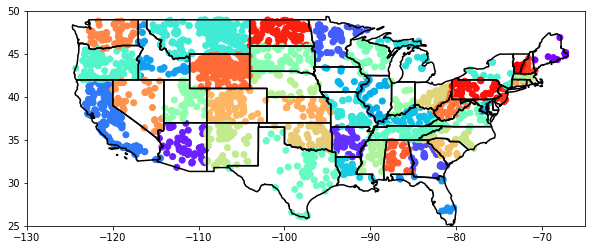

In [227]:
fig, ax = plt.subplots(figsize=(10,5))

p1 = classification.plot(column='regions_index', ax=ax, cmap='rainbow')
p1.set_xlim(x1, x2)
p1.set_ylim(y1, y2)

p2 = regions.geometry.boundary.plot(ax=ax, color="k", edgecolor='k')
p2.set_xlim(x1, x2)
p2.set_ylim(y1, y2)

plt.show()

In [219]:
classification[classification.regions_index == 35]

,meta_index,LONGITUDE,LATITUDE,geometry,regions_index
meta_index,,,,,
851,851,-82.858330,38.646671,POINT (-82.85833000000002 38.64667100000001),35
858,858,-84.150000,39.022500,POINT (-84.15000000000001 39.0225),35
2244,2244,-82.326668,40.603329,POINT (-82.32666800000001 40.603329),35
2245,2245,-81.846672,40.156670,POINT (-81.846672 40.15667),35
2246,2246,-81.360370,40.568220,POINT (-81.36036999999997 40.56822),35
2247,2247,-81.298740,40.651170,POINT (-81.29874000000002 40.65117),35
2248,2248,-81.594460,40.702510,POINT (-81.59446 40.70251),35
2249,2249,-81.285004,40.526669,POINT (-81.285004 40.526669),35
2250,2250,-82.157220,40.074610,POINT (-82.15722 40.07461),35


In [183]:
classification.head()

,meta_index,LONGITUDE,LATITUDE,geometry,regions_index
meta_index,,,,,
0,0,-149.808334,61.288333,POINT (-149.808334 61.28833299999999),7
1,1,-134.660000,56.398333,POINT (-134.66 56.39833333),7
2,2,-147.167011,64.733514,POINT (-147.1670111 64.73351389),7
3,3,-148.921493,60.800942,POINT (-148.9214927 60.80094221),7
4,4,-85.878337,33.463161,POINT (-85.87833695 33.46316083),45


# Original Meta

In [181]:
meta.head()

,meta_index,LONGITUDE,LATITUDE,geometry
meta_index,,,,
0,0,-149.808334,61.288333,POINT (-149.808334 61.28833299999999)
1,1,-134.660000,56.398333,POINT (-134.66 56.39833333)
2,2,-147.167011,64.733514,POINT (-147.1670111 64.73351389)
3,3,-148.921493,60.800942,POINT (-148.9214927 60.80094221)
4,4,-85.878337,33.463161,POINT (-85.87833695 33.46316083)


# Original Regions

In [225]:
regions

,NAME,geometry,LONGITUDE,LATITUDE
NAME,,,,
Maine,Maine,"(POLYGON ((-68.92401 43.885407, -68.8747839999...",-69.214010,45.343271
Hawaii,Hawaii,"(POLYGON ((-156.049651 19.780452, -156.006267 ...",-156.357528,20.256447
Arizona,Arizona,"POLYGON ((-114.799683 32.593621, -114.809393 3...",-111.664482,34.292828
Arkansas,Arkansas,POLYGON ((-94.61791900000001 36.49941400000001...,-92.437854,34.900017
Delaware,Delaware,"POLYGON ((-75.773786 39.7222, -75.753227999999...",-75.500949,39.000628
Georgia,Georgia,"POLYGON ((-85.605165 34.984678, -85.4743388431...",-83.443361,32.648095
Minnesota,Minnesota,"POLYGON ((-97.229039 49.000687, -96.93096 48.9...",-94.306336,46.317930
Alaska,Alaska,"(POLYGON ((179.481318 51.97530099999999, 179.5...",-152.076694,64.102456
California,California,"(POLYGON ((-118.593969 33.467198, -118.484785 ...",-119.611120,37.242215
